In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

#### Code 7.1

In [3]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

#### Code 7.2

In [195]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -77.024: 100%|██████████| 200000/200000 [00:25<00:00, 7954.03it/s]
Finished [100%]: Average ELBO = -77.028
100%|██████████| 1000/1000 [00:02<00:00, 371.79it/s]


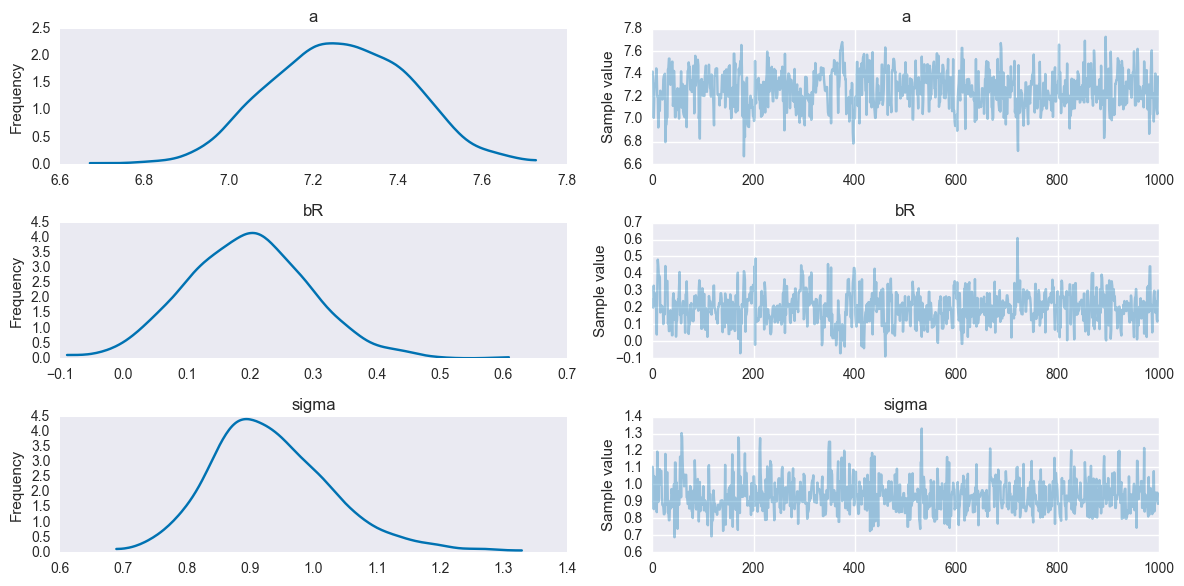

In [55]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [196]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -179.55: 100%|██████████| 200000/200000 [00:24<00:00, 8026.12it/s]
Finished [100%]: Average ELBO = -179.55
100%|██████████| 1000/1000 [00:03<00:00, 293.24it/s]


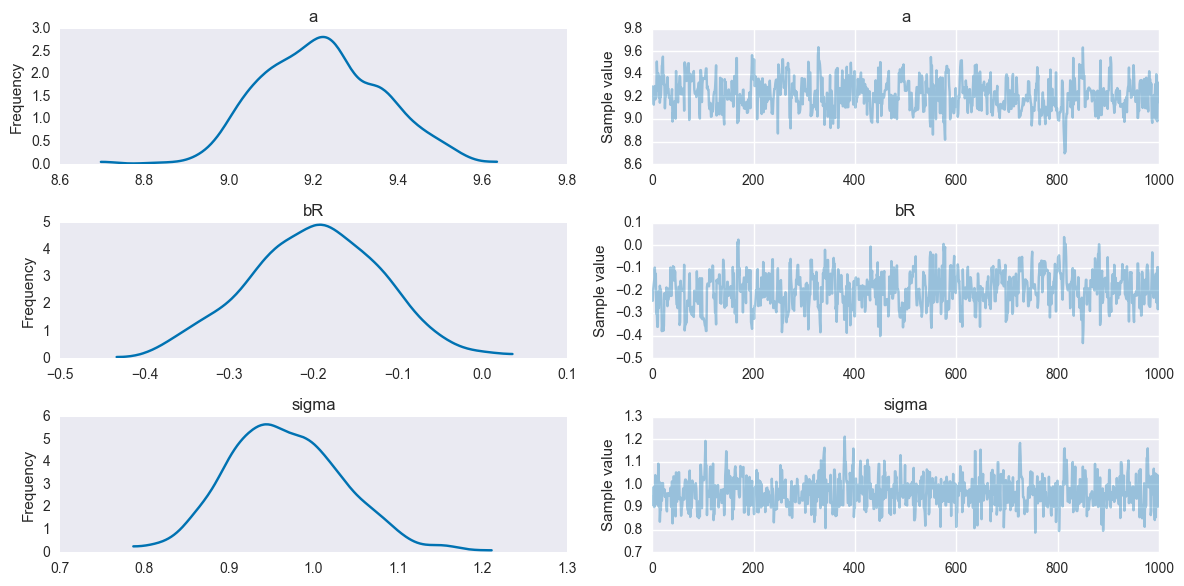

In [58]:
pm.traceplot(trace_7_2_2, varnames);

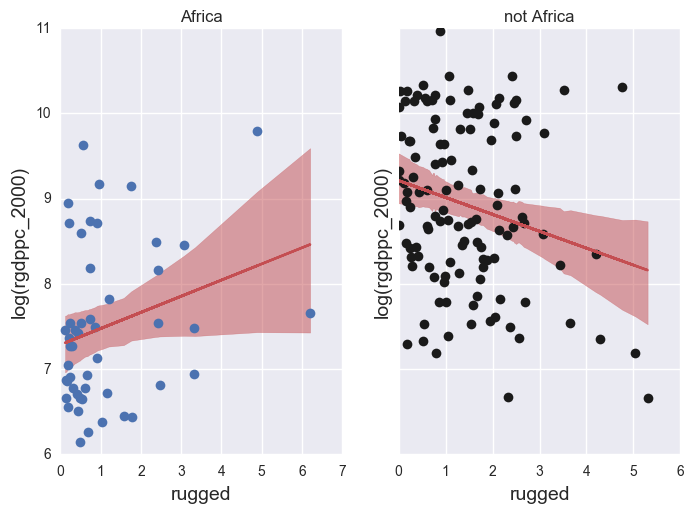

In [228]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'r')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'r')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
plt.show()

#### Code 7.3

In [10]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -281.09: 100%|██████████| 200000/200000 [00:25<00:00, 7867.69it/s]
Finished [100%]: Average ELBO = -281.07
100%|██████████| 1000/1000 [00:03<00:00, 292.70it/s]


#### Code 7.4

In [6]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -251.62: 100%|██████████| 200000/200000 [00:26<00:00, 7599.08it/s]
Finished [100%]: Average ELBO = -251.64
100%|██████████| 1000/1000 [00:04<00:00, 222.24it/s]


#### Code 7.5

In [7]:
def compare_waic(mod1, trace1, mod2, trace2):
    '''Compare fitted models using widely applicable information criterion.'''
    waic1 = pm.stats.waic(model=mod1, trace=trace1, pointwise=True)
    waic2 = pm.stats.waic(model=mod2, trace=trace2, pointwise=True)
    
    # Calculate diff in expected predictive accuracy
    diff = waic2[2] - waic1[2]
    d_waic = np.sum(diff)
    d_se = np.sqrt(len(diff)) * np.var(diff)
    
    print "     \tWAIC \tpWAIC \tdWAIC \tSE \tdSE"
    print "mod1  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic1[0], waic1[3], np.abs(d_waic), waic1[1], d_se)
    print "mod2  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic2[0], waic2[3], np.abs(d_waic), waic2[1], d_se)

In [20]:
compare_waic(model_7_3, trace_7_3, model_7_4, trace_7_4)

     	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	539.1 	2.4 	62.6 	13.0 	16.5
mod2  	476.5 	4.4 	62.6 	14.8 	16.5


#### Code 7.6

Since the link function isn't implemented we have to compute the mean over samples ourselves using a loop.

In [227]:
rugged_seq = np.arange(-1, 9, 0.35)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4)))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4)))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1

In [212]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

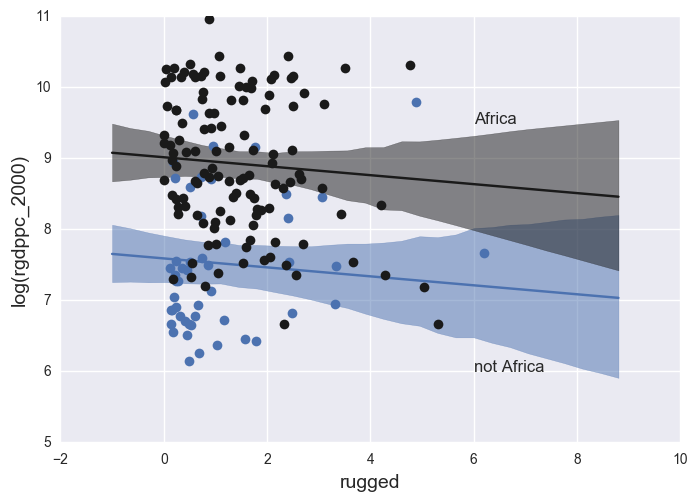

In [226]:
plt.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
plt.plot(rugged_seq, mu_mean_Africa, 'b')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
plt.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
plt.annotate('Africa', xy=(6, 9.5))
plt.annotate('not Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14);
plt.xlabel('rugged', fontsize=14)
plt.show()

#### Code 7.7

In [5]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -250.64: 100%|██████████| 200000/200000 [00:29<00:00, 6896.14it/s]
Finished [100%]: Average ELBO = -250.68
100%|██████████| 1000/1000 [00:05<00:00, 177.81it/s]


#### Code 7.8

In [8]:
compare_waic(model_7_4, trace_7_4, model_7_5, trace_7_5)

/home/raid2/mihai/.local/lib/python2.7/site-packages/pymc3/stats.py:146: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


     	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	475.6 	3.9 	7.1 	14.8 	2.7
mod2  	468.6 	4.7 	7.1 	14.4 	2.7


In [11]:
compare_waic(model_7_3, trace_7_3, model_7_5, trace_7_5)

     	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	539.4 	2.5 	70.8 	12.9 	16.1
mod2  	468.6 	4.7 	70.8 	14.4 	16.1


#### Code 7.9

In [4]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -250.66: 100%|██████████| 200000/200000 [00:28<00:00, 6904.30it/s]
Finished [100%]: Average ELBO = -250.67
100%|██████████| 1000/1000 [00:06<00:00, 160.02it/s]


#### Code 7.10
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.


In [34]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b)))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b)))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [35]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

#### Code 7.11

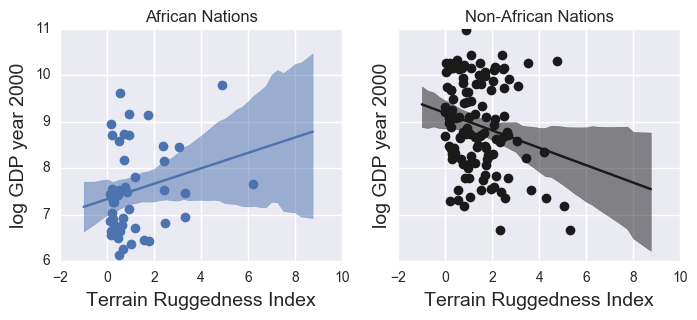

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(rugged_seq, mu_mean_Africa, 'b')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14)
plt.show()

#### Code 7.12

In [11]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
vars = pm.df_summary(trace_7_5b, varnames)
print vars

           mean        sd  mc_error   hpd_2.5  hpd_97.5
a      9.188545  0.140380  0.008161  8.911326  9.468797
bA    -1.850767  0.221609  0.012178 -2.275380 -1.404640
bR    -0.186883  0.076557  0.004527 -0.322851 -0.018113
bAR    0.352638  0.128673  0.006478  0.099397  0.602033
sigma  0.953268  0.054194  0.001806  0.853431  1.057565


The MAP slope relating ruggedness to log-GDP within Africa is:

In [27]:
gamma_Africa = vars['mean']['bR'] + vars['mean']['bAR'] * 1
gamma_notAfrica = vars['mean']['bR'] + vars['mean']['bAR'] * 0
print "Gamma within Africa: %.2f" %gamma_Africa
print "Gamma outside Africa: %.2f" %gamma_notAfrica

Gamma within Africa 0.17
Gamma outside Africa -0.19


#### Code 7.13

In [30]:
post = pm.trace_to_dataframe(trace_7_5b)
gamma_Africa = post.bR + post.bAR * 1
gamma_notAfrica = post.bR + post.bAR * 0

#### Code 7.14

In [33]:
print np.mean(gamma_Africa)
print np.mean(gamma_notAfrica)

0.16575495013
-0.186882646306


#### Code 7.15

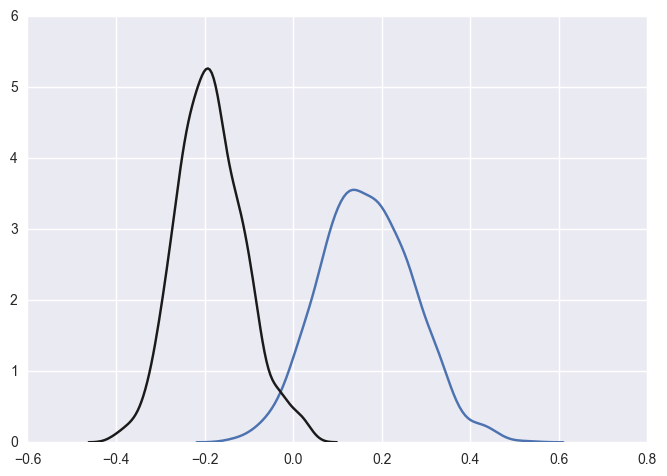

In [75]:
sns.kdeplot(gamma_Africa, color='b')
sns.kdeplot(gamma_notAfrica, color='k')
plt.show()

#### Code 7.16

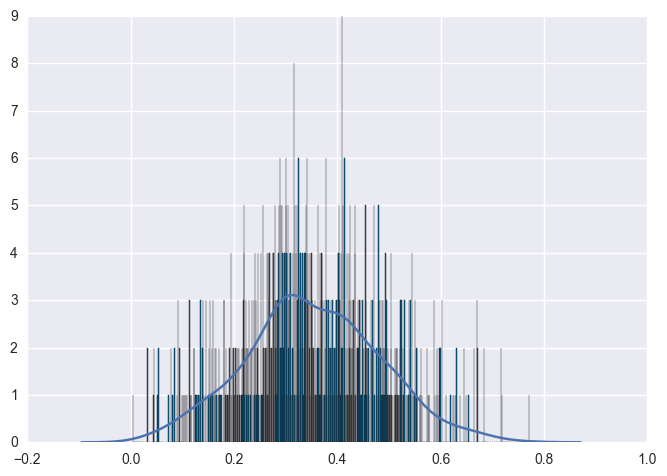

In [70]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
sns.kdeplot(diff, color='b')
hist, bins = np.histogram(diff, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
# Notice that there are no values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [72]:
sum(diff[diff<0]) / float(len(diff))

0.0

#### Code 7.17

In [79]:
# Get min and max rugged values
q_rugged = [0, 0]
q_rugged[0] = np.min(dd.rugged)
q_rugged[1] = np.max(dd.rugged)

[0.0030000000000000001, 6.2020000000000008]


In [ ]:
# Compute lines and confidence intervals

In [116]:
#### Code 7.16

In [117]:
#### Code 7.17

In [118]:
#### Code 7.19

In [119]:
#### Code 7.20

In [120]:
### Code 7.21